In [2]:
from src.datasets.qm9_smiles_generation import QM9Smiles

from __future__ import annotations
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.data import Dataset


def analyze_dataset(ds: Dataset, name: str = "", feature_attr: str = "x") -> dict:
    """
    Compute statistics for a PyG dataset with 4-tuple node features
    and draw histograms for node counts, edge counts, and node-type distribution.
    """
    num_nodes_list, num_edges_list = [], []
    node_type_counter = Counter()
    logp_list: list[float] = []  # <-- collect logP if available

    for data in ds:
        n = int(data.num_nodes)
        e = int(data.num_edges) // 2  # dataset is undirected
        num_nodes_list.append(n)
        num_edges_list.append(e)

        x: torch.Tensor = getattr(data, feature_attr)
        if x.dim() != 2 or x.size(1) != 4:
            raise ValueError(f"Expected {feature_attr} shape [N, 4], got {tuple(x.shape)}")
        rows = x.detach().cpu().to(torch.int64).tolist()
        node_type_counter.update(map(tuple, rows))

        # --- logP (optional) ---
        if hasattr(data, "logp"):
            lp = data.logp
            # accept scalar tensor or 1-element tensor
            if isinstance(lp, torch.Tensor):
                lp = float(lp.detach().cpu().reshape(-1)[0])
            else:
                lp = float(lp)
            logp_list.append(lp)

    def stats(arr):
        arr = np.asarray(arr)
        return {
            "min": int(arr.min()),
            "max": int(arr.max()),
            "mean": float(arr.mean()),
            "median": float(np.median(arr)),
            "std": float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        }

    summary = {
        "dataset": name,
        "num_graphs": len(ds),
        "nodes": stats(num_nodes_list),
        "edges": stats(num_edges_list),
        "total_node_types": len(node_type_counter),
        "node_type_distribution": dict(node_type_counter),
    }

    if logp_list:
        summary["logp"] = stats(logp_list)  # include logP stats if present


    # --- plotting ---
    fig = plt.figure(figsize=(16, 10))  # wider and taller canvas
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 3])  # bottom row 3x taller

    ax_nodes = fig.add_subplot(gs[0, 0])
    ax_edges = fig.add_subplot(gs[0, 1])
    ax_types = fig.add_subplot(gs[1, :])  # spans the whole width

    # Add a little more margin at the bottom so rotated labels fit
    plt.subplots_adjust(bottom=0.25)

    # Node count distribution
    ax_nodes.hist(num_nodes_list, bins=30, color="steelblue", edgecolor="black")
    ax_nodes.set_title(f"{name} – Node count distribution")
    ax_nodes.set_xlabel("num_nodes")
    ax_nodes.set_ylabel("frequency")

    # Edge count distribution
    ax_edges.hist(num_edges_list, bins=30, color="darkorange", edgecolor="black")
    ax_edges.set_title(f"{name} – Edge count distribution")
    ax_edges.set_xlabel("num_edges")
    ax_edges.set_ylabel("frequency")

    # Node type distribution (wider)
    if node_type_counter:
        labels, counts = zip(*node_type_counter.most_common())
        ax_types.bar(range(len(labels)), counts, color="seagreen", edgecolor="black")
        ax_types.set_xticks(range(len(labels)))
        ax_types.set_xticklabels([str(l) for l in labels], rotation=90, fontsize=8)
    ax_types.set_title(f"{name} – Node type distribution")
    ax_types.set_xlabel("node type (tuple)")
    ax_types.set_ylabel("count")

    plt.tight_layout()
    plt.show()

    # --- separate logP plot (only if available) ---
    if logp_list:
        fig2 = plt.figure(figsize=(8, 5))
        ax_logp = fig2.add_subplot(1, 1, 1)
        ax_logp.hist(logp_list, bins=50, edgecolor="black")
        ax_logp.set_title(f"{name} – logP distribution")
        ax_logp.set_xlabel("cLogP (RDKit)")
        ax_logp.set_ylabel("frequency")
        plt.tight_layout()
        plt.show()

    return summary


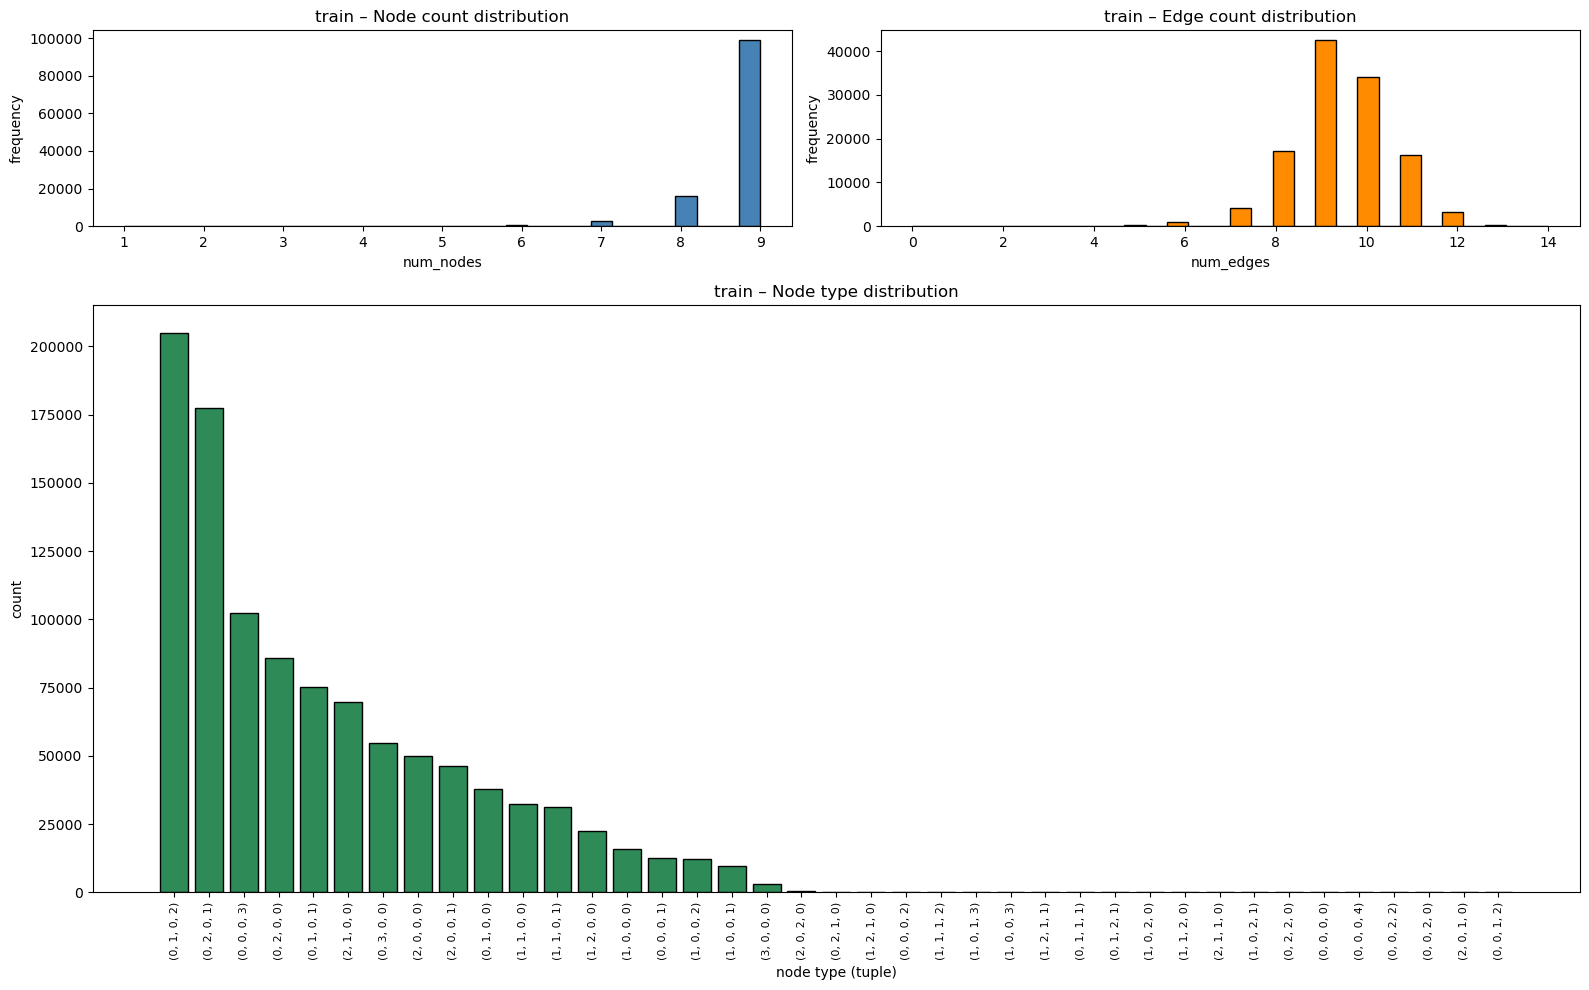

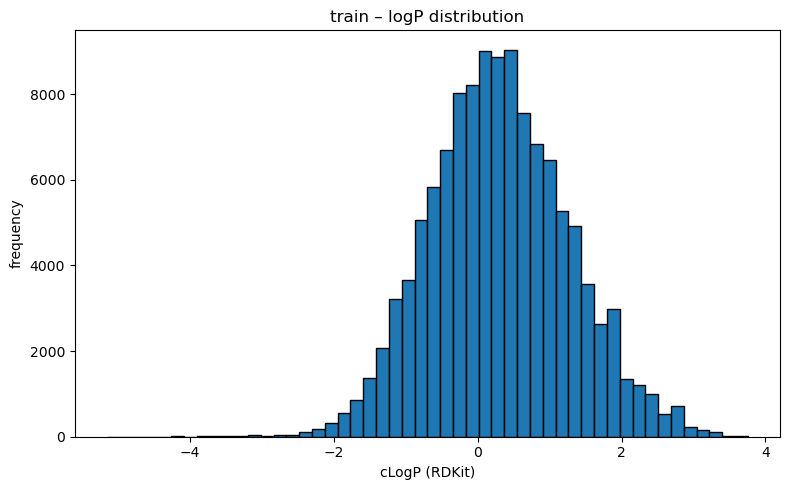

{'dataset': 'train',
 'edges': {'max': 14,
           'mean': 9.396537655935868,
           'median': 9.0,
           'min': 0,
           'std': 1.1682700245850308},
 'logp': {'max': 3,
          'mean': 0.30487121410781287,
          'median': 0.27810001373291016,
          'min': -5,
          'std': 0.9661976604136703},
 'node_type_distribution': {(0, 0, 0, 0): 2,
                            (0, 0, 0, 1): 12653,
                            (0, 0, 0, 2): 92,
                            (0, 0, 0, 3): 102500,
                            (0, 0, 0, 4): 1,
                            (0, 0, 1, 2): 1,
                            (0, 0, 2, 0): 1,
                            (0, 0, 2, 2): 1,
                            (0, 1, 0, 0): 37875,
                            (0, 1, 0, 1): 75277,
                            (0, 1, 0, 2): 204962,
                            (0, 1, 1, 1): 24,
                            (0, 1, 2, 1): 15,
                            (0, 2, 0, 0): 85894,
               

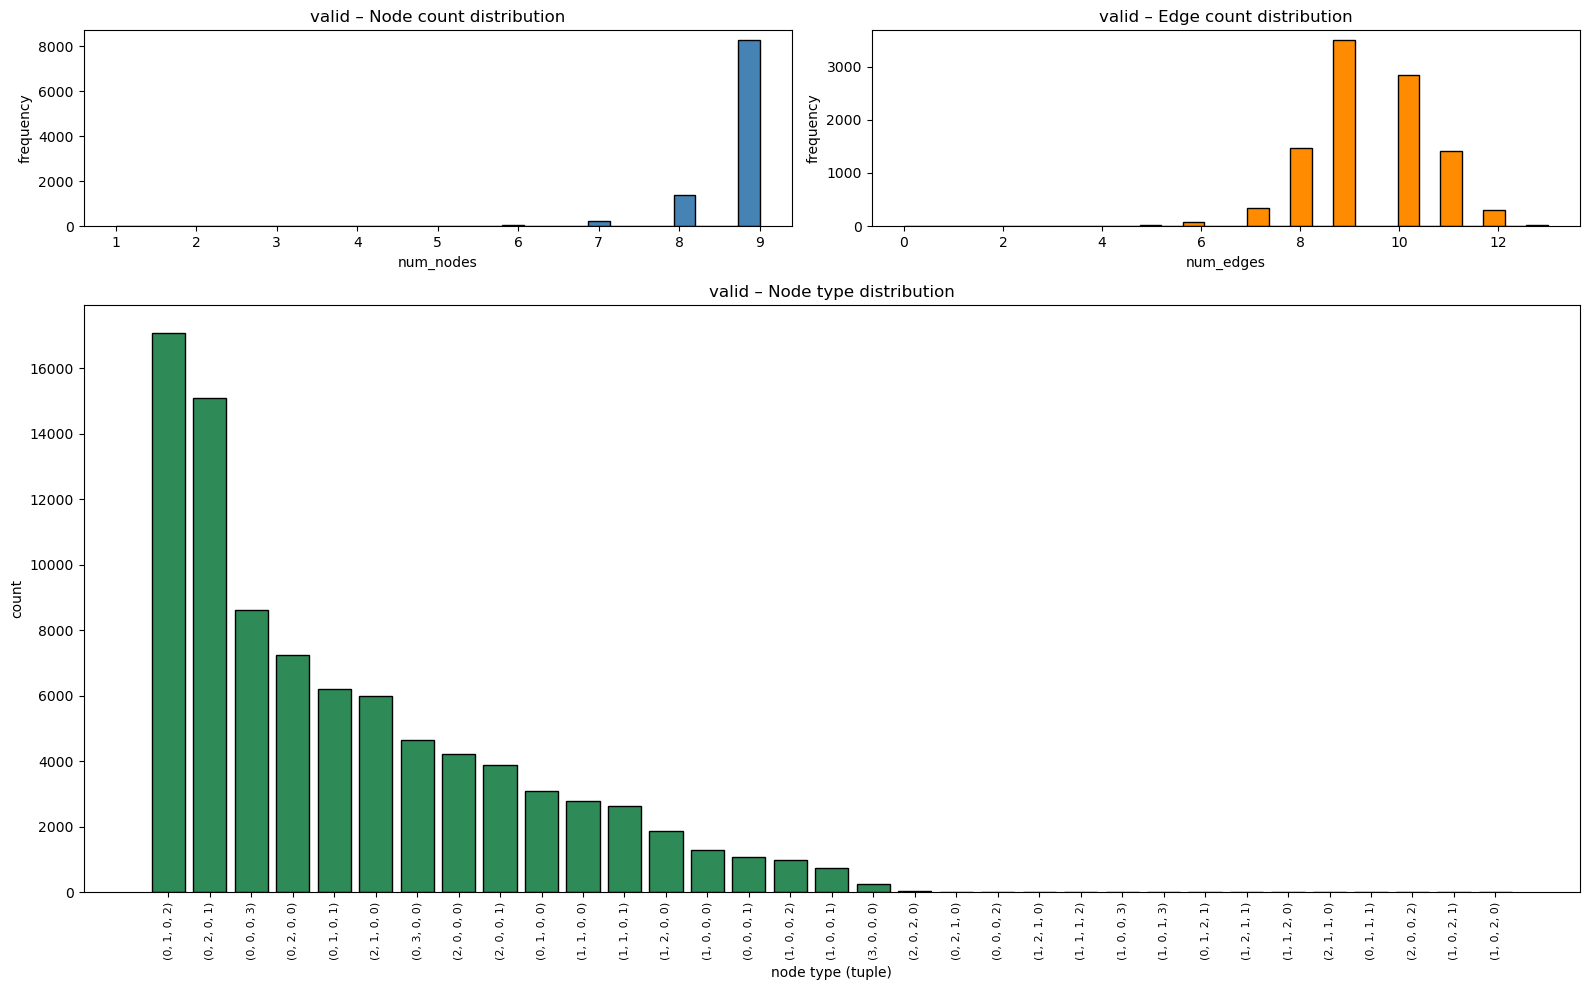

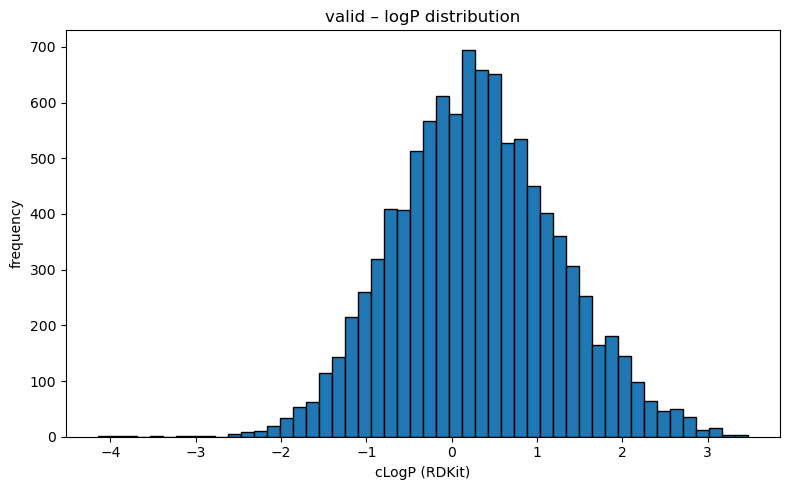

{'dataset': 'valid',
 'edges': {'max': 13,
           'mean': 9.411,
           'median': 9.0,
           'min': 0,
           'std': 1.182716737806728},
 'logp': {'max': 3,
          'mean': 0.2900216716815892,
          'median': 0.26197999715805054,
          'min': -4,
          'std': 0.9493566984068311},
 'node_type_distribution': {(0, 0, 0, 1): 1084,
                            (0, 0, 0, 2): 12,
                            (0, 0, 0, 3): 8616,
                            (0, 1, 0, 0): 3105,
                            (0, 1, 0, 1): 6205,
                            (0, 1, 0, 2): 17084,
                            (0, 1, 1, 1): 1,
                            (0, 1, 2, 1): 2,
                            (0, 2, 0, 0): 7249,
                            (0, 2, 0, 1): 15105,
                            (0, 2, 1, 0): 13,
                            (0, 3, 0, 0): 4649,
                            (1, 0, 0, 0): 1309,
                            (1, 0, 0, 1): 732,
                         

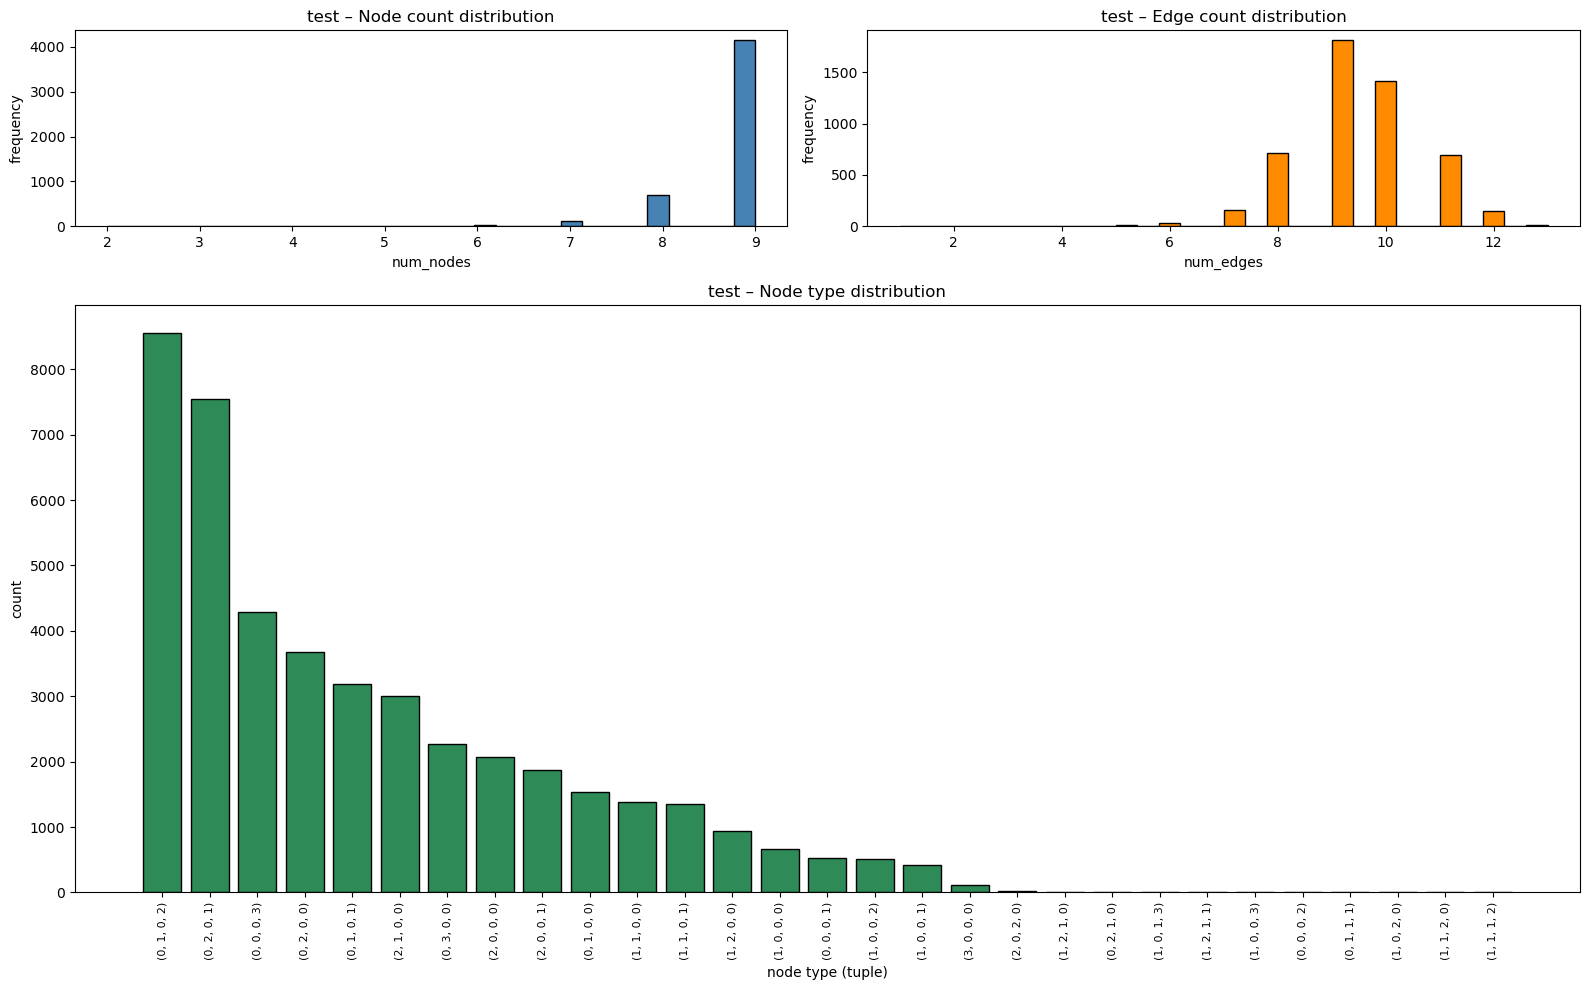

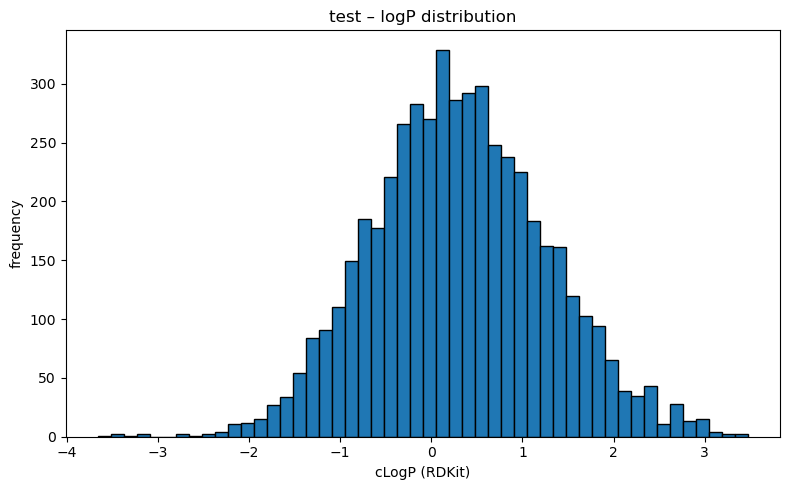

{'dataset': 'test',
 'edges': {'max': 13,
           'mean': 9.417,
           'median': 9.0,
           'min': 1,
           'std': 1.155931760809058},
 'logp': {'max': 3,
          'mean': 0.3070138343619852,
          'median': 0.27950000762939453,
          'min': -3,
          'std': 0.9605054019158015},
 'node_type_distribution': {(0, 0, 0, 1): 525,
                            (0, 0, 0, 2): 3,
                            (0, 0, 0, 3): 4288,
                            (0, 1, 0, 0): 1534,
                            (0, 1, 0, 1): 3191,
                            (0, 1, 0, 2): 8555,
                            (0, 1, 1, 1): 2,
                            (0, 2, 0, 0): 3672,
                            (0, 2, 0, 1): 7543,
                            (0, 2, 1, 0): 6,
                            (0, 3, 0, 0): 2276,
                            (1, 0, 0, 0): 665,
                            (1, 0, 0, 1): 422,
                            (1, 0, 0, 2): 516,
                            (1

In [4]:
from pprint import pprint

for split in ["train", "valid", "test"]:
    ds = QM9Smiles(split=split, enc_suffix="HRR1600")
    stats = analyze_dataset(ds, name=split)
    pprint(stats)